In [3]:
%matplotlib inline

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn import preprocessing as preproc, datasets, linear_model 

pd.set_option('html', False)
np.set_printoptions(threshold=np.nan)

# Data Preprocessing

In [22]:
url = 'https://blockchain.info/charts/%s?timespan=all&format=csv'
charts = ['market-price',
          'market-cap', 
          'transaction-fees-usd', 
          'n-transactions', 
          'n-unique-addresses', 
          'n-transactions-per-block',
          'n-orphaned-blocks',
          'output-volume',
          'estimated-transaction-volume-usd',
          'trade-volume',
          'tx-trade-ratio',
          'cost-per-transaction',
          'hash-rate',
          'difficulty',
          'miners-revenue',
          'median-confirmation-time',
          'bitcoin-days-destroyed',
          'avg-block-size'
         ]

frames = []   # contains everything as dataframes from charts
features = [] # contains everything as dataframes from charts except the market-price, values are standardized

dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y %H:%M:%S')

data = pd.read_csv(url % charts[0], parse_dates=[0], date_parser = dateparse)
data.columns = ['date', charts[0]]
    
df = pd.DataFrame(data)
df['date'] = df['date'].apply(lambda x: x.date())
df = df.drop_duplicates(['date']).set_index('date').reindex(pd.date_range(start = '1/4/2012', end = '3/06/2016'))
frames.append(df)

for chart in charts[1:]:
    data = pd.read_csv(url % chart, parse_dates=[0], date_parser = dateparse)
    data.columns = ['date', chart]
    
    df = pd.DataFrame(data)
    df['date'] = df['date'].apply(lambda x: x.date())
    df = df.drop_duplicates(['date']).set_index('date').reindex(pd.date_range(start = '1/4/2012', end = '3/06/2016'))
    frames.append(df)
    
    data_np = df.as_matrix()
    scaler = preproc.StandardScaler().fit(data_np)
    data_np_standard = scaler.transform(data_np)
    
    df_standard = pd.DataFrame(data=data_np_standard, index=df.index, columns=df.columns)
    features.append(df_standard)
    
#btc_dataset = pd.DataFrame(data=features)
#btc_dataset = btc_dataset.set_index('market-price')

# Setup the genetic algorithm and initialize the population

In [23]:
def filterFeatures (mask):
    return list (map (lambda t: t[1], filter (lambda t: t[0], zip(mask, features))))

def fitnessFun (indiv):
    filteredFeatures = filterFeatures(indiv)
    size = len(filteredFeatures)
    features = pd.concat(filteredFeatures, axis = 1)
    btc_features = pd.DataFrame(features.values).as_matrix()
    btc_target = pd.DataFrame(frames[0]).as_matrix().flatten()
    
    # 70% of the data will be used for training,
    # 30% will be used for testing.
    # Later on a 60:20:20 split will be used
    # for training, validation and testing respectively. 

    btc_X_train = btc_features[:int(0.7*len(btc_features))]
    btc_X_test = btc_features[int(0.7*len(btc_features)):]

    btc_y_train = btc_target[:int(0.7*len(btc_target))]
    btc_y_test = btc_target[int(0.7*len(btc_target)):]

    # Create the learner

    regr = linear_model.LinearRegression()

    # Train the learner on the training data
    # and evaluate the performance by the test data

    regr.fit(btc_X_train, btc_y_train)
    print ('Variance score: %.2f, %d' % (regr.score(btc_X_test, btc_y_test), size))
    
    return regr.score(btc_X_test, btc_y_test), size

creator.create("FitnessMulti", base.Fitness, weights=(1.0,-1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti) 

# Linear Regression with R<sup>2</sup> statistic as fitness function for GA (take a look at: gaussian process bayesian regression)

In [37]:
# Concatenate the features in order to group them by date

toolb = base.Toolbox()
toolb.register('bit', random.randint, 0, 1)
toolb.register('individual', tools.initRepeat, creator.Individual, toolb.bit, n = len(features))
toolb.register('population', tools.initRepeat, list, toolb.individual, n = 22)
toolb.register('evaluate', fitnessFun)
toolb.register('mate', tools.cxUniform, indpb = 0.1)
toolb.register('mutate', tools.mutFlipBit, indpb = 0.05)
toolb.register('select', tools.selNSGA2)

population = toolb.population()
fits = map (toolb.evaluate, population)
for fit, ind in zip(fits, population):
    ind.fitness.values = fit

for gen in range(50):
    offspring = algorithms.varOr(population, toolb, lambda_ = 22, cxpb = 0.5, mutpb = 0.1)
    fits = map (toolb.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolb.select(offspring + population, k = 22)
    
print(population)



Variance score: -5.03, 9
Variance score: -6.43, 7
Variance score: 0.88, 8
Variance score: -1.30, 7
Variance score: -1.46, 8
Variance score: -0.73, 8
Variance score: -1.76, 9
Variance score: 0.91, 9
Variance score: 0.91, 11
Variance score: 0.91, 11
Variance score: 0.93, 9
Variance score: -4.95, 8
Variance score: 0.88, 11
Variance score: -2.44, 10
Variance score: -1.63, 7
Variance score: 0.98, 5
Variance score: -3.45, 6
Variance score: 0.95, 9
Variance score: -4.32, 10
Variance score: 0.95, 12
Variance score: -4.40, 10
Variance score: 0.80, 5
Variance score: 0.82, 6
Variance score: 0.94, 8
Variance score: -1.30, 7
Variance score: 0.93, 9
Variance score: -1.92, 9
Variance score: -4.32, 10
Variance score: -1.30, 7
Variance score: -1.22, 6
Variance score: -1.63, 7
Variance score: -4.40, 10
Variance score: -4.95, 8
Variance score: 0.91, 11
Variance score: 0.91, 11
Variance score: -1.63, 7
Variance score: -0.73, 8
Variance score: -3.45, 6
Variance score: 0.91, 9
Variance score: -1.41, 7
Varia

# Visualizing the actual and predicted prices 

AttributeError: 'list' object has no attribute 'plot'

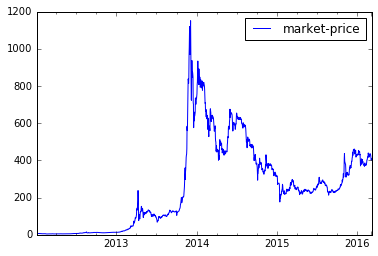

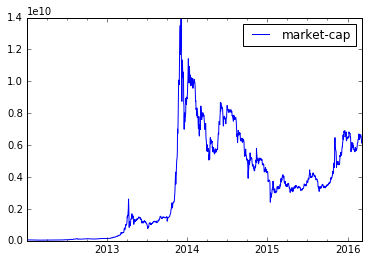

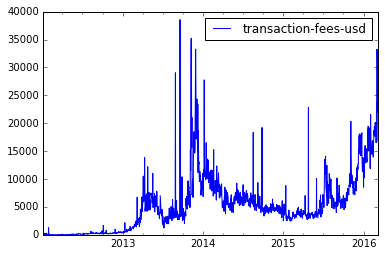

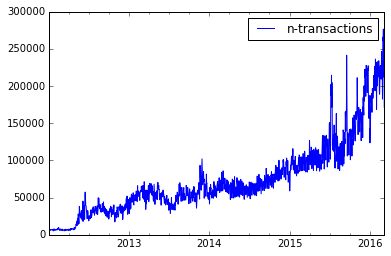

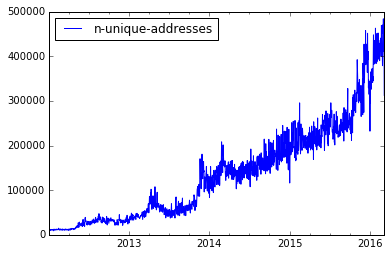

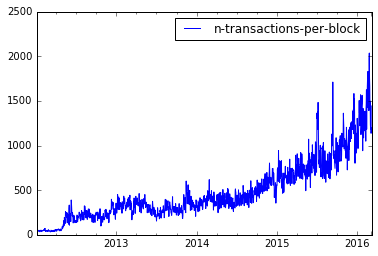

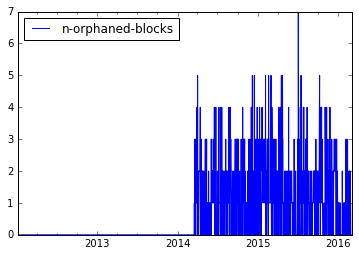

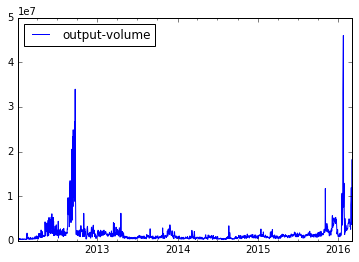

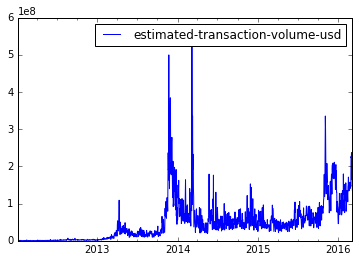

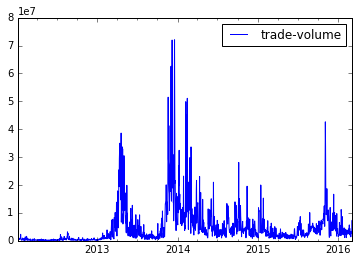

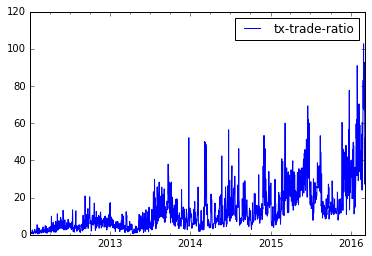

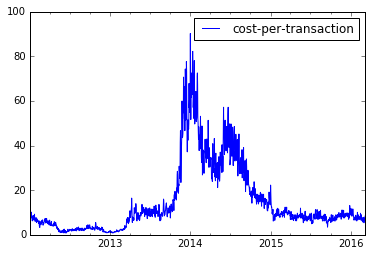

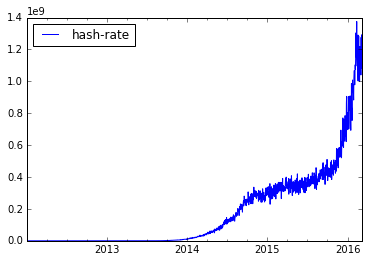

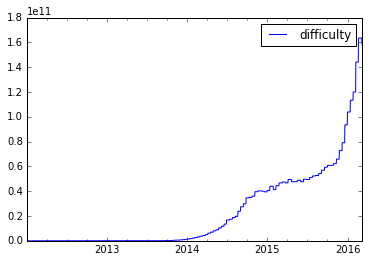

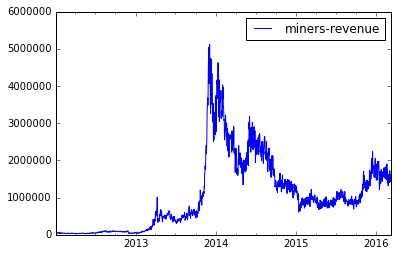

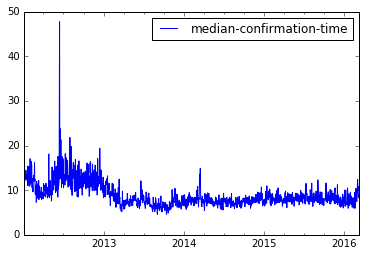

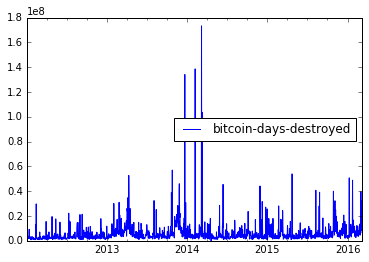

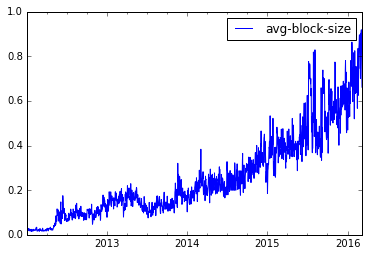

In [33]:
for f in frames:
    f.plot()
    

features.plot(figsize = (25,25))


In [34]:
plt.figure(figsize = (10,10))
plt.plot(features.index[int(0.7*len(btc_target)):], btc_y_test, label = 'Actual Prices')
plt.plot(features.index[int(0.7*len(btc_target)):], regr.predict(btc_X_test), label = 'Predicted Prices')
plt.legend(loc = 'best')

NameError: name 'btc_target' is not defined

# Price values

In [ ]:
compare_df = pd.DataFrame(data = list(zip(btc_y_test, regr.predict(btc_X_test))), 
                          index = features.index[int(0.7*len(btc_target)):], 
                          columns = ['actual', 'predicted'])
compare_df